<a href="https://colab.research.google.com/github/Eddietrantkt/CF_Quan22280073_Tuong22280102/blob/main/FINANCE_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas matplotlib mplfinance prophet scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.6 MB/s eta 0:00:00


# Import Python Libraries and set defalut value

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
start_time = "2021-01-01"
end_time = datetime.now()
ngan_hang_vn = ["VCB.VN", "TCB.VN", "ACB.VN", "MBB.VN", "BID.VN", "CTG.VN", "HDB.VN", "TPB.VN", "MSB.VN", "SHB.VN"]

# Download price-volume data

In [4]:
data = yf.download(ngan_hang_vn, start=start_time, end=end_time, auto_adjust=False)
data.tail(3)

[*********************100%***********************]  10 of 10 completed


Price      Adj Close                                                        \
Ticker        ACB.VN   BID.VN   CTG.VN   HDB.VN   MBB.VN   MSB.VN   SHB.VN   
Date                                                                         
2025-10-29   25400.0  37800.0  49650.0  33400.0  24350.0  12550.0  16800.0   
2025-10-30   25100.0  37900.0  49200.0  33400.0  23950.0  12350.0  16900.0   
2025-10-31   25500.0  37400.0  49000.0  32000.0  23600.0  12050.0  16450.0   

Price                                       ...    Volume                      \
Ticker       TCB.VN        TPB.VN   VCB.VN  ...    ACB.VN   BID.VN     CTG.VN   
Date                                        ...                                 
2025-10-29  36400.0  17285.714844  60700.0  ...  36658230  3207848  7481263.0   
2025-10-30  35700.0  17150.000000  60600.0  ...   9720545  2602763  4884057.0   
2025-10-31  35100.0  16650.000000  59600.0  ...  16827430  2378179  9974477.0   

Price                                                                        \
Ticker        HDB.VN    MBB.VN    MSB.VN       SHB.VN      TCB.VN    TPB.VN   
Date                                                                          
2025-10-29  34754610  28514760  10878080  118173800.0  13774450.0  11699005   
2025-10-30  23793070  27235650   4419336   71866010.0  10679850.0   5644447   
2025-10-31  24986310  20228190  10067250   46967260.0  12815550.0   8961570   

Price                
Ticker       VCB.VN  
Date                 
2025-10-29  4465810  
2025-10-30  1951674  
2025-10-31  2394883  

[3 rows x 60 columns]

# Convert to DataFrame

In [5]:
data_stacked = data.stack(level='Ticker')
data_long = data_stacked.reset_index()
data_long = data_long.rename_axis(None, axis=1)
data_long = data_long.rename(columns={
    'Adj Close': 'Adjust Close',
    'Date': 'Date'
})
desired_columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjust Close', 'Volume']
final_columns = [col for col in desired_columns if col in data_long.columns]
data_final = data_long[final_columns]
# Đổi tên cột Ticker thành Ngan_hang_VN
data_final = data_final.rename(columns={'Ticker': 'Ngan_hang_VN'})
# Chuyển cột Date dùng làm Index
data_final = data_final.set_index('Date')

/tmp/ipython-input-1521832300.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_stacked = data.stack(level='Ticker')


In [6]:
df = data_final

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho BID.VN: 0.54


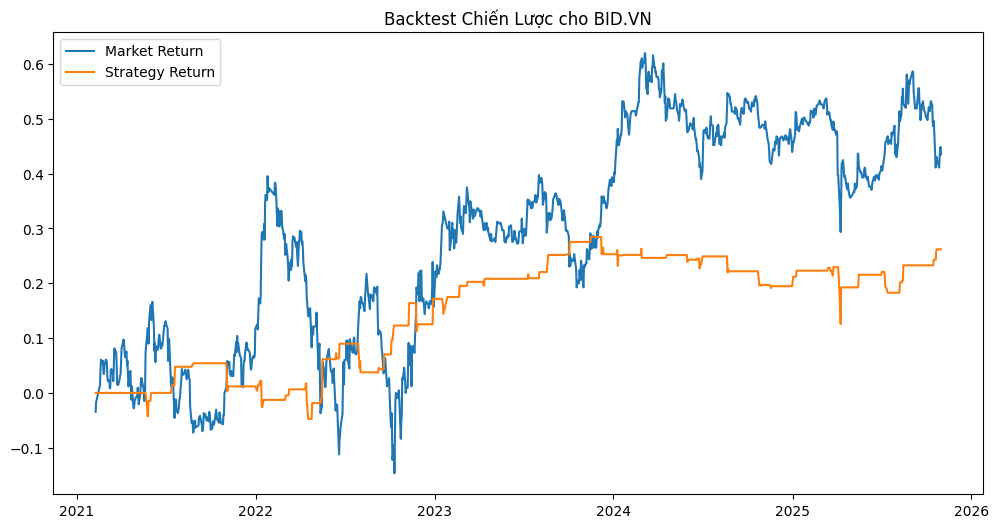

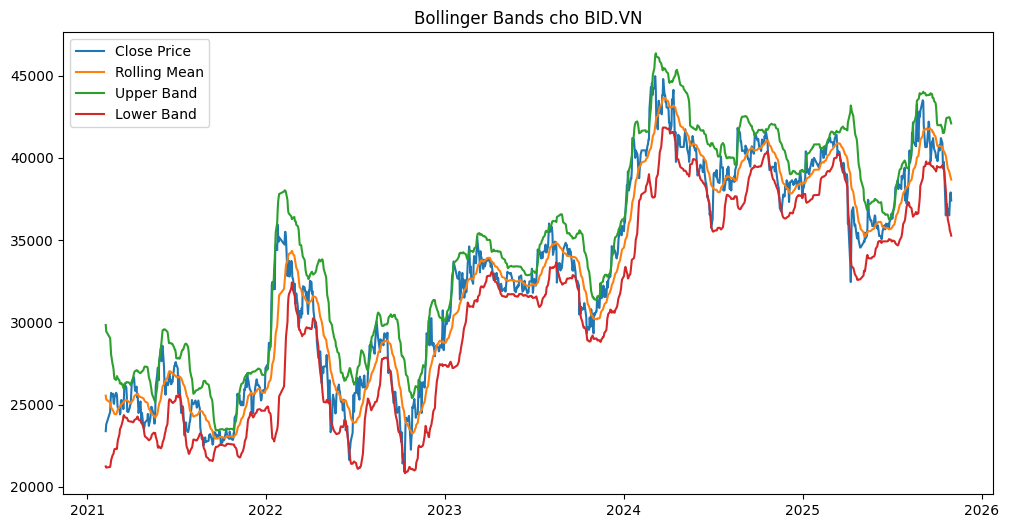

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho CTG.VN: 0.18


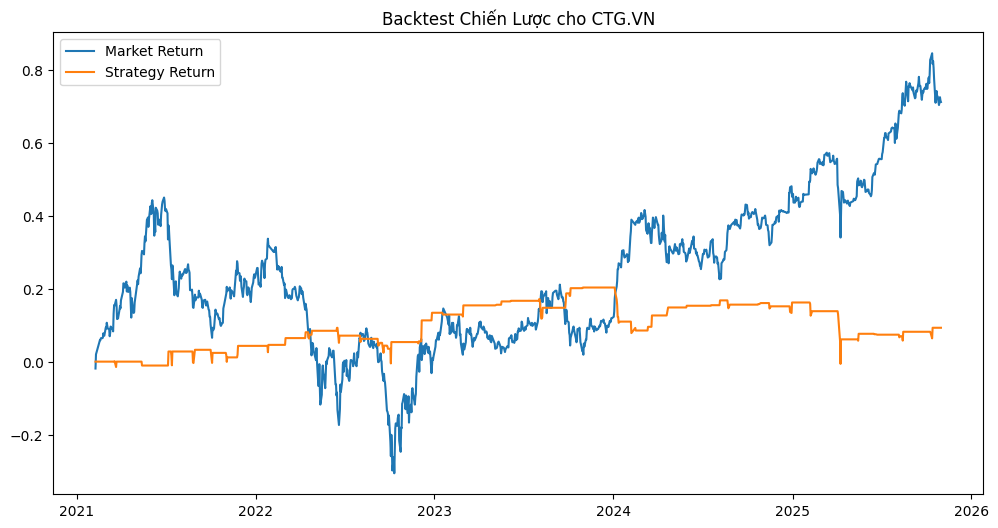

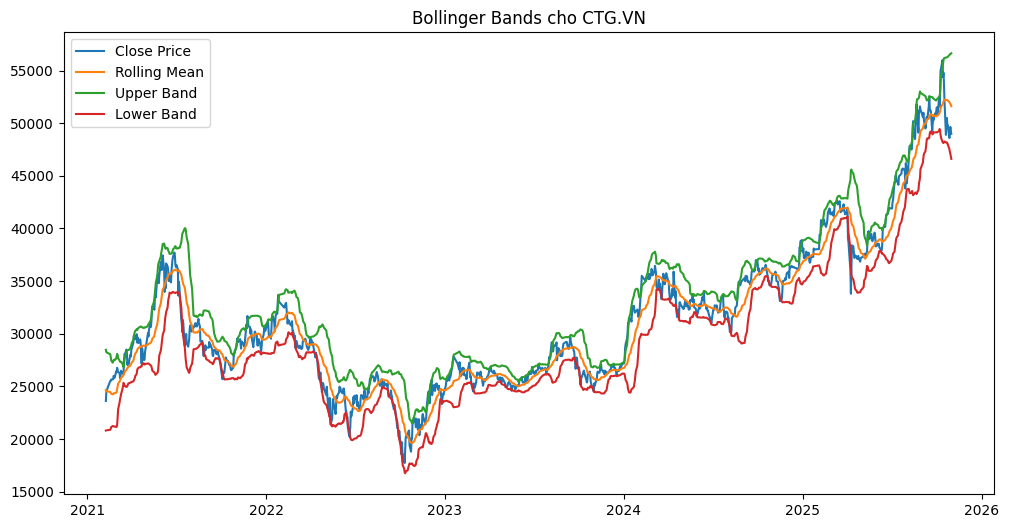

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Sharpe Ratio của chiến lược cho HDB.VN: 0.30


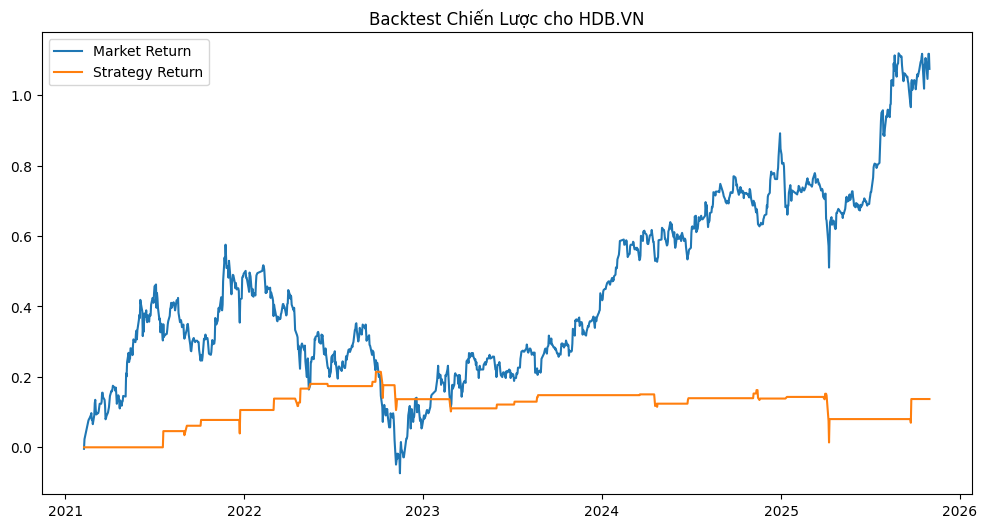

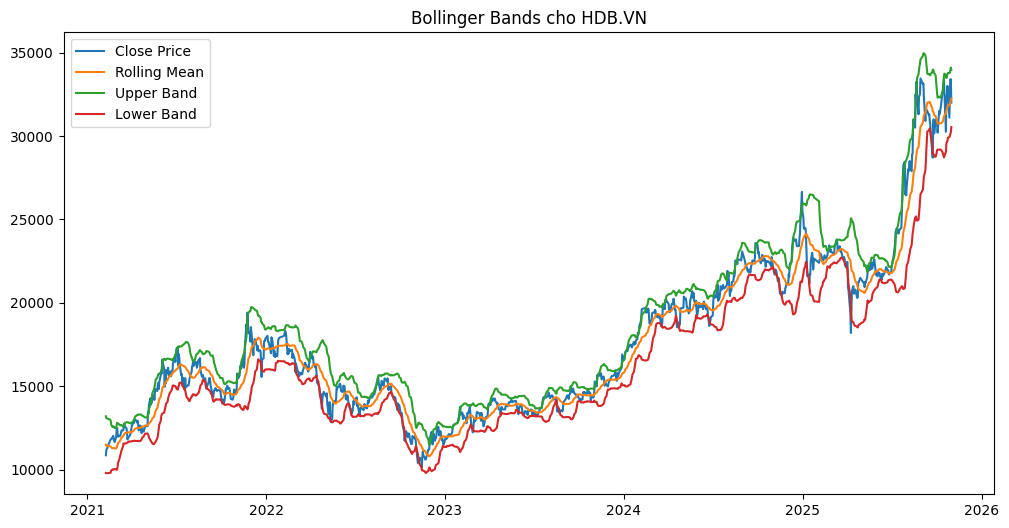

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho MBB.VN: 0.30


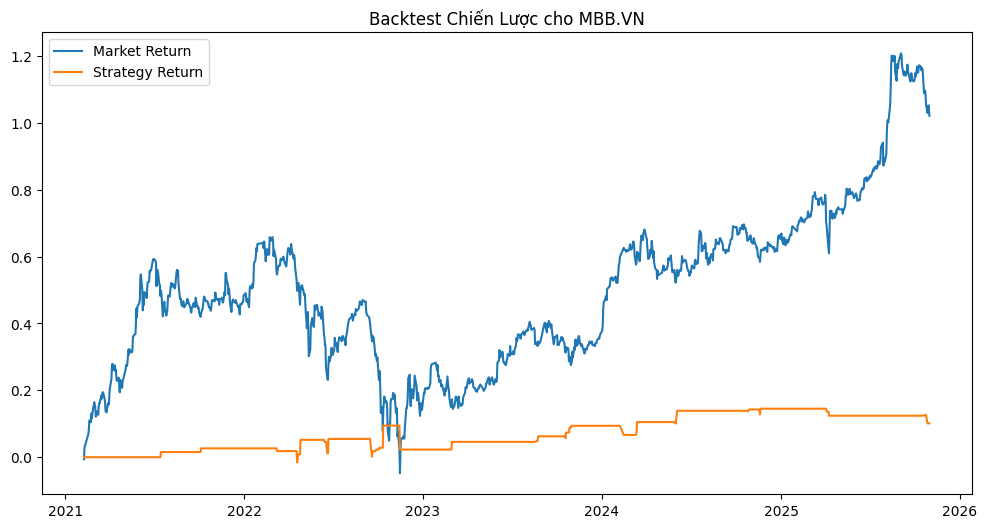

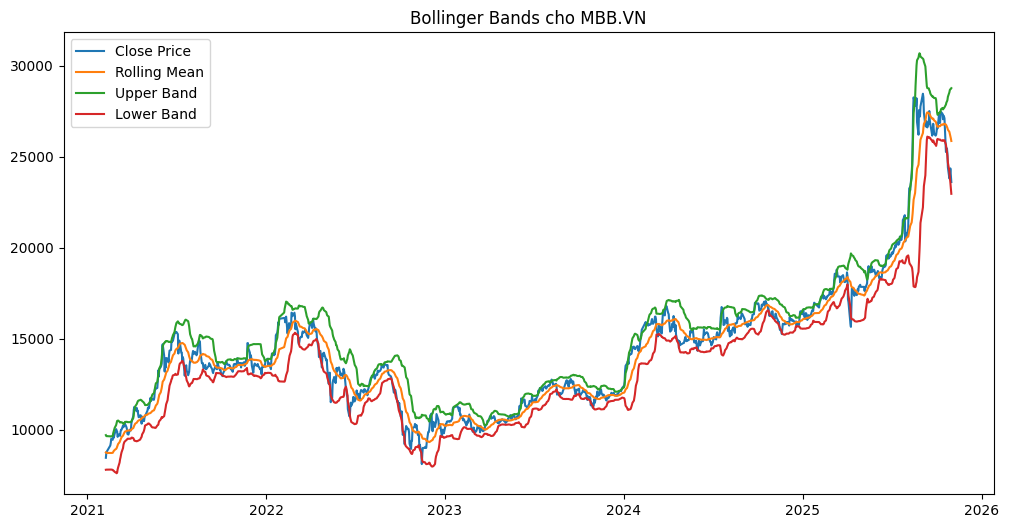

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho MSB.VN: 0.02


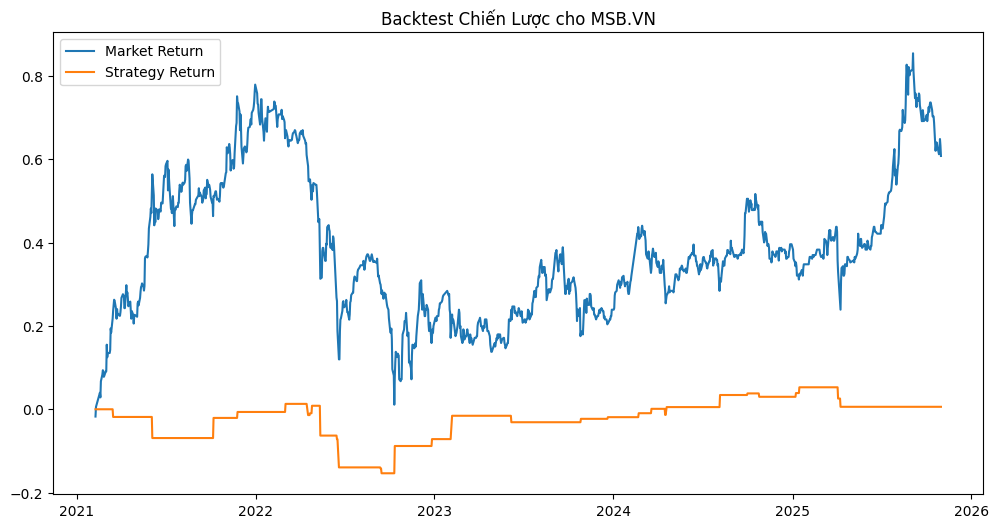

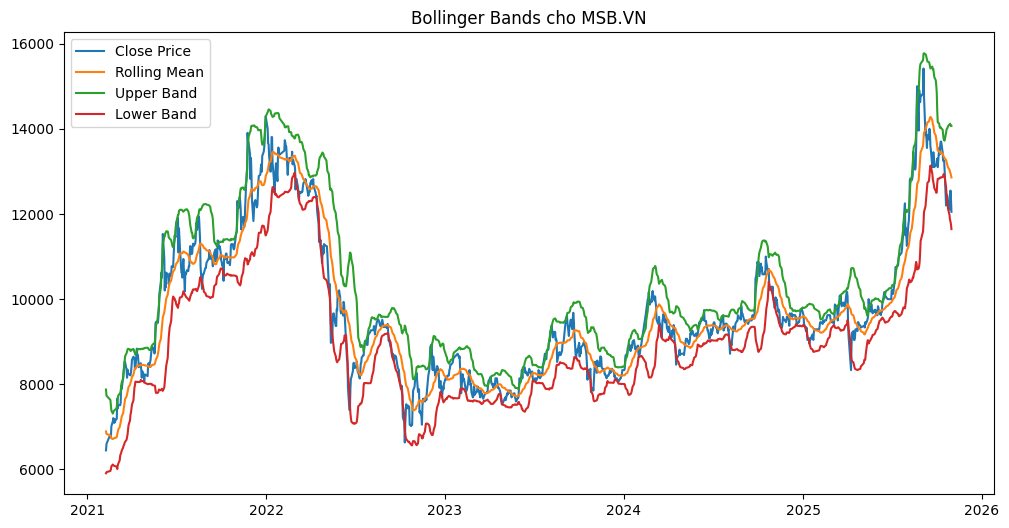

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho SHB.VN: -0.42


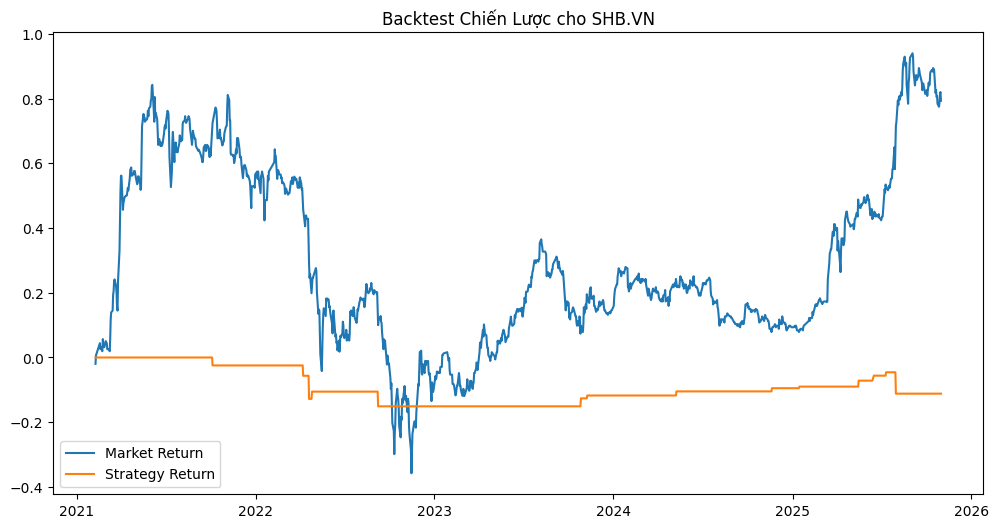

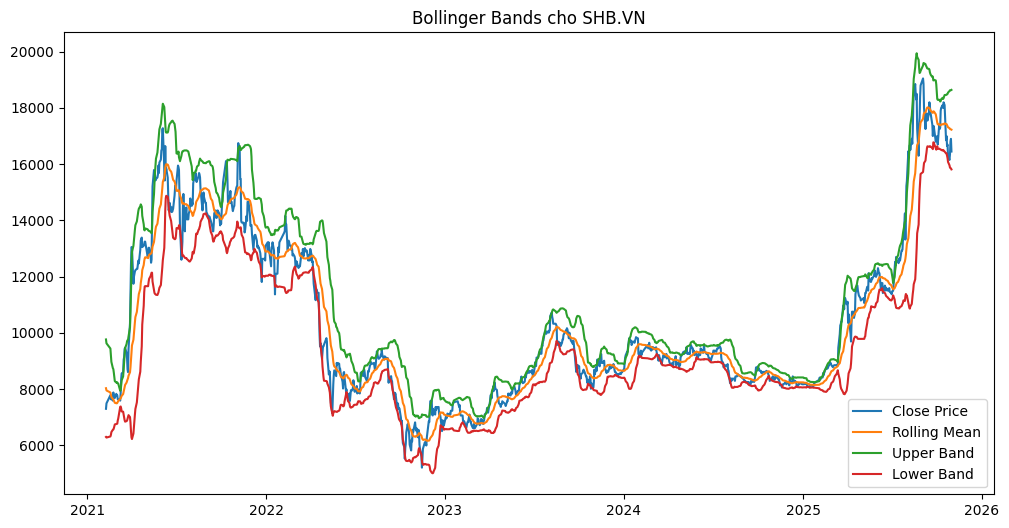

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho TCB.VN: -0.79


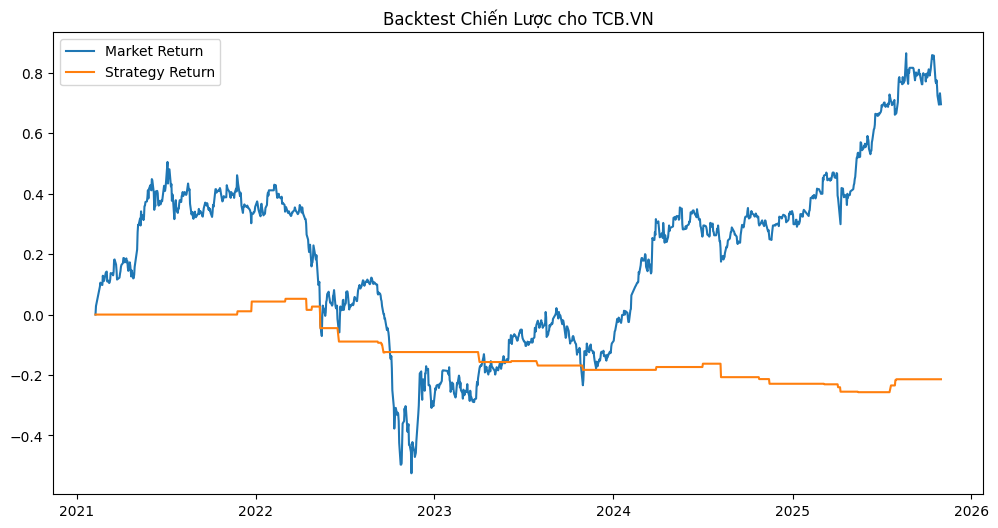

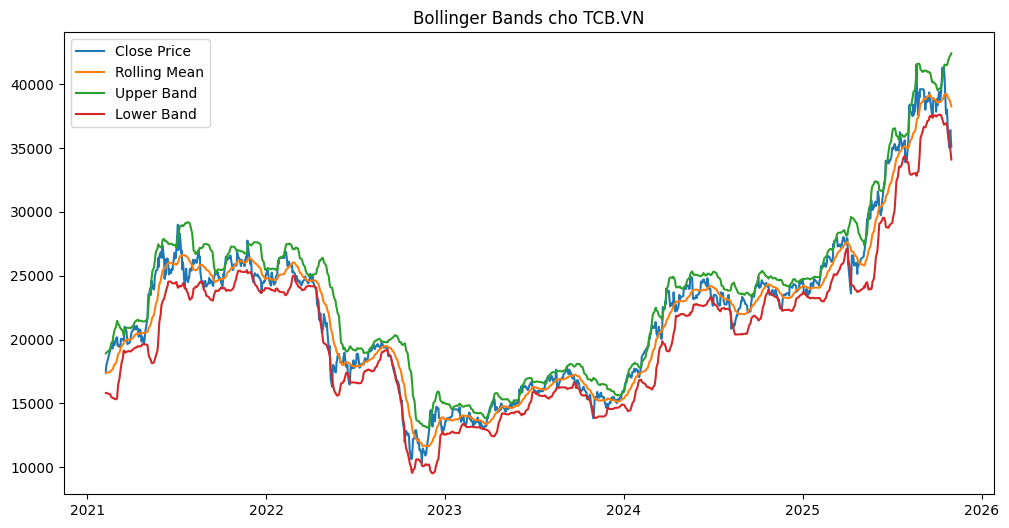

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho TPB.VN: 0.51


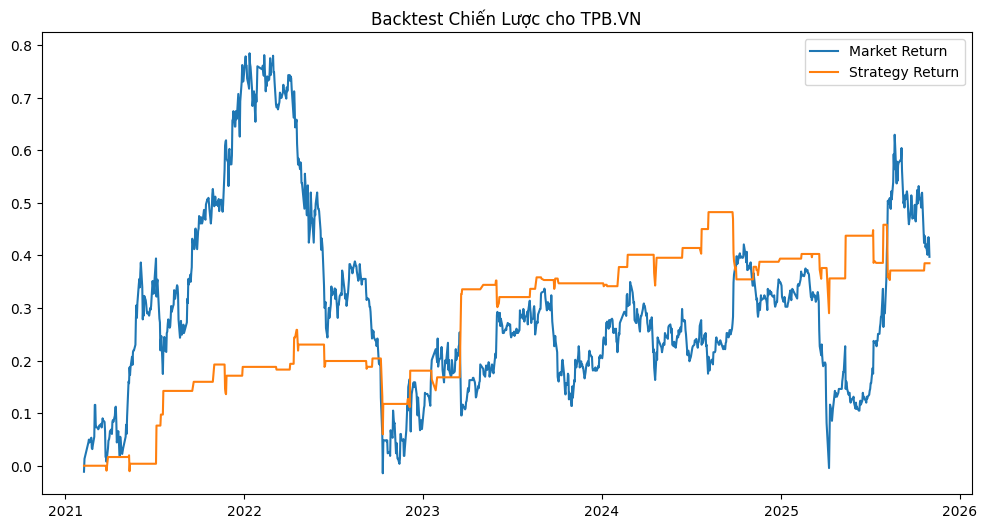

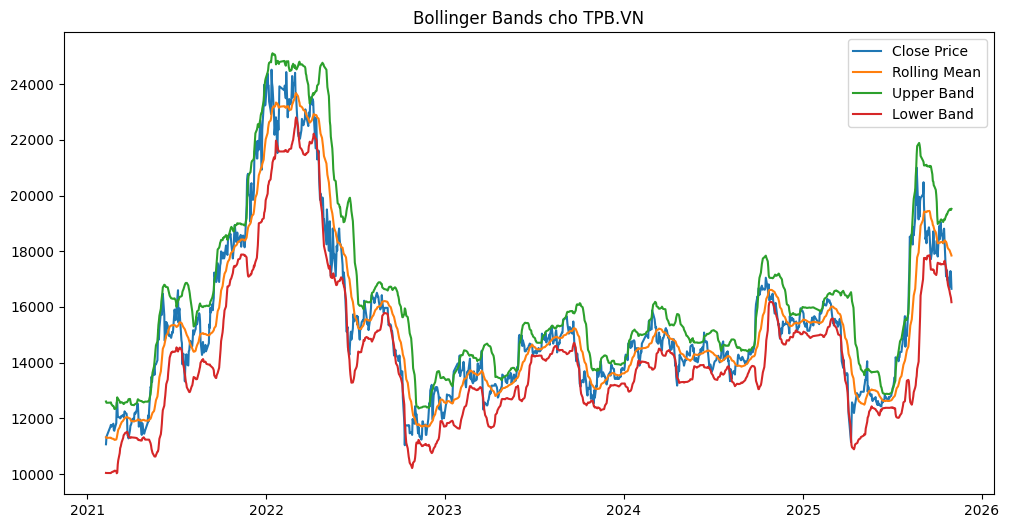

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Sharpe Ratio của chiến lược cho VCB.VN: -0.22


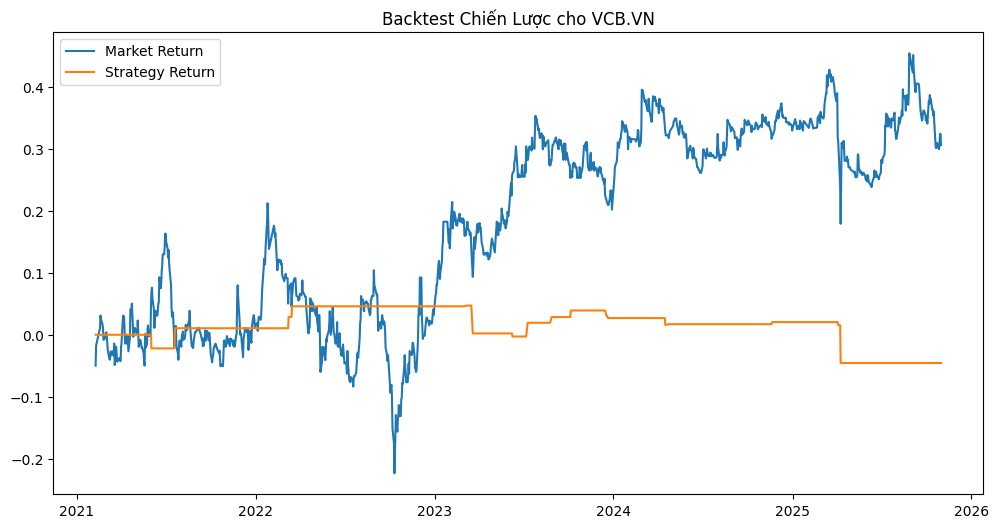

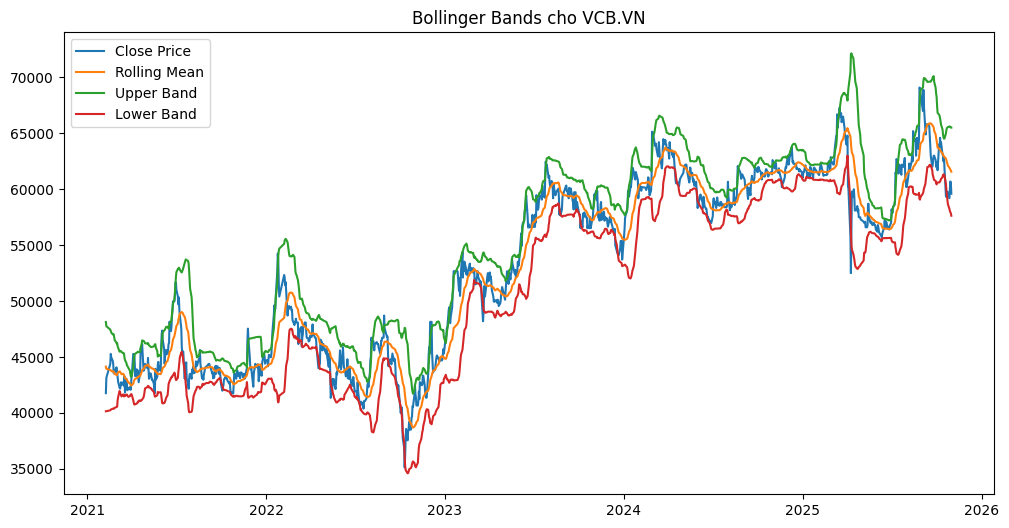

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược cho ACB.VN: 0.03


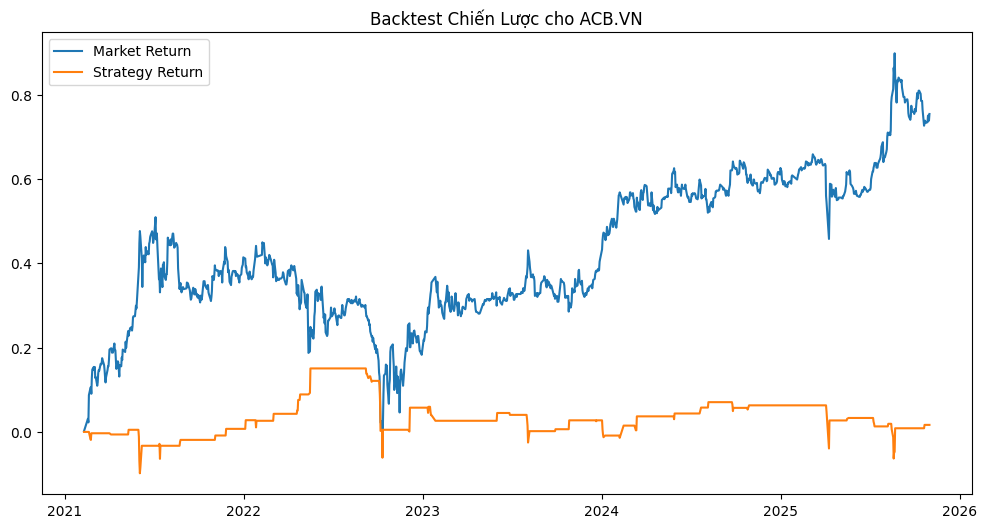

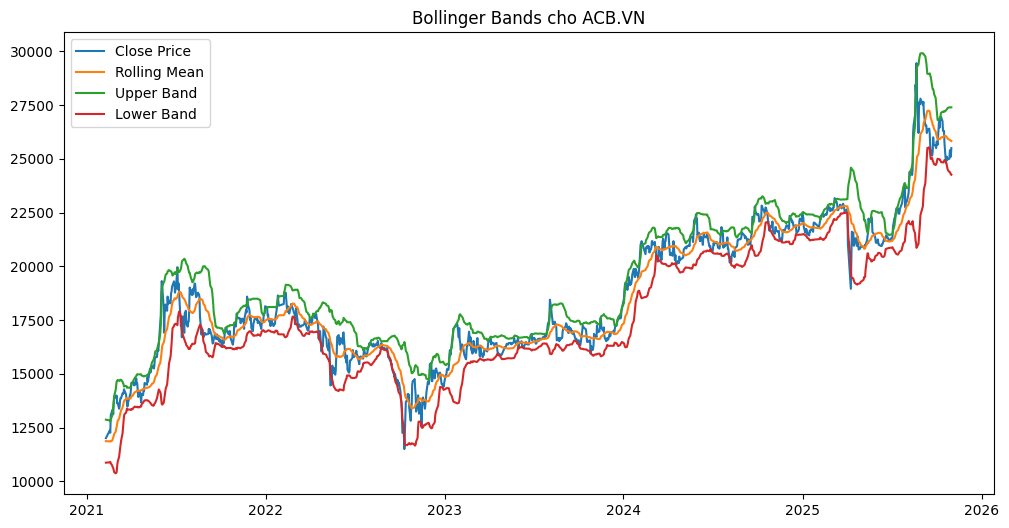

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA # Import ARIMA

# Get unique tickers
tickers = df['Ngan_hang_VN'].unique()

for ticker in tickers:
    df_ticker = df[df['Ngan_hang_VN'] == ticker].copy()

    df_ticker['Log_Return'] = np.log(df_ticker['Close'] / df_ticker['Close'].shift(1))
    df_ticker.dropna(inplace=True)

    # Check if the DataFrame is empty after dropping NaNs
    if df_ticker.empty:
        print(f"Error: DataFrame for {ticker} is empty after dropping initial NaNs. Cannot fit ARIMA model.")
        continue

    # Bước 2: Áp dụng Time Series Modeling - Fit ARIMA để dự báo log returns
    # Chọn order (p,d,q) đơn giản: (1,0,1) - Bạn có thể dùng auto_arima để tối ưu
    try:
        model = ARIMA(df_ticker['Log_Return'], order=(1,0,1))
        model_fit = model.fit()
        forecast_steps = 1  # Dự báo 1 ngày tiếp theo
        # Predict on the same index as df_ticker
        df_ticker['Forecast'] = model_fit.predict(start=0, end=len(df_ticker)-1)
    except Exception as e:
        print(f"Error fitting ARIMA model for {ticker}: {e}")
        continue

    # Bước 3: Áp dụng Volatility - Tính Bollinger Bands
    window = 20  # Window cho mean và std
    df_ticker['Rolling_Mean'] = df_ticker['Close'].rolling(window=window).mean()
    df_ticker['Rolling_Std'] = df_ticker['Close'].rolling(window=window).std()
    df_ticker['Upper_Band'] = df_ticker['Rolling_Mean'] + (df_ticker['Rolling_Std'] * 2)
    df_ticker['Lower_Band'] = df_ticker['Rolling_Mean'] - (df_ticker['Rolling_Std'] * 2)

    # Drop NaNs after calculating Bollinger Bands and Forecast
    df_ticker.dropna(inplace=True)

    # Check again if the DataFrame is empty after dropping NaNs from Bollinger Bands
    if df_ticker.empty:
        print(f"Error: DataFrame for {ticker} is empty after calculating and dropping NaNs from Bollinger Bands.")
        continue
    else:
        df_ticker['Signal'] = 0

        # Perform boolean comparisons separately to ensure alignment is handled
        buy_condition = (df_ticker['Close'] < df_ticker['Lower_Band']) & (df_ticker['Forecast'] > 0)
        sell_condition = (df_ticker['Close'] > df_ticker['Upper_Band']) & (df_ticker['Forecast'] < 0)

        # Use the boolean series in np.where
        df_ticker['Signal'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))


        # Tính position: Giả sử bắt đầu từ hold, thay đổi khi có signal
        df_ticker['Position'] = df_ticker['Signal'].shift(1)  # Shift để tránh lookahead bias

        # Bước 5: Backtest - Tính lợi nhuận
        df_ticker['Strategy_Return'] = df_ticker['Position'] * df_ticker['Log_Return']
        df_ticker['Cumulative_Market'] = np.cumsum(df_ticker['Log_Return'])  # Lợi nhuận thị trường
        df_ticker['Cumulative_Strategy'] = np.cumsum(df_ticker['Strategy_Return'])  # Lợi nhuận chiến lược

        # Drop NaNs again after calculating returns if any were introduced by shifting Position
        df_ticker.dropna(inplace=True)

        # Check one last time if the DataFrame is empty before calculating Sharpe Ratio and plotting
        if df_ticker.empty:
             print(f"Error: DataFrame for {ticker} is empty after calculating returns.")
             continue
        else:
            # Tính Sharpe Ratio (giả sử risk-free rate = 0)
            sharpe_ratio = (df_ticker['Strategy_Return'].mean() / df_ticker['Strategy_Return'].std()) * np.sqrt(252)  # Annualized

            print(f"Sharpe Ratio của chiến lược cho {ticker}: {sharpe_ratio:.2f}")

            # Vẽ biểu đồ backtest
            plt.figure(figsize=(12, 6))
            plt.plot(df_ticker['Cumulative_Market'], label='Market Return')
            plt.plot(df_ticker['Cumulative_Strategy'], label='Strategy Return')
            plt.title(f'Backtest Chiến Lược cho {ticker}')
            plt.legend()
            plt.show()

            # Vẽ Bollinger Bands
            plt.figure(figsize=(12, 6))
            plt.plot(df_ticker['Close'], label='Close Price')
            plt.plot(df_ticker['Rolling_Mean'], label='Rolling Mean')
            plt.plot(df_ticker['Upper_Band'], label='Upper Band')
            plt.plot(df_ticker['Lower_Band'], label='Lower Band')
            plt.title(f'Bollinger Bands cho {ticker}')
            plt.legend()
            plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Sharpe Ratio của chiến lược: 0.48


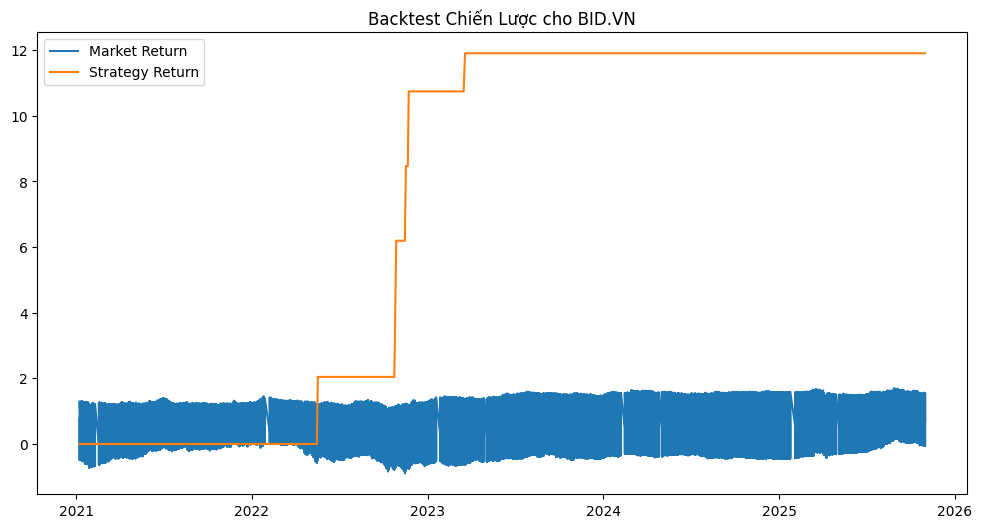

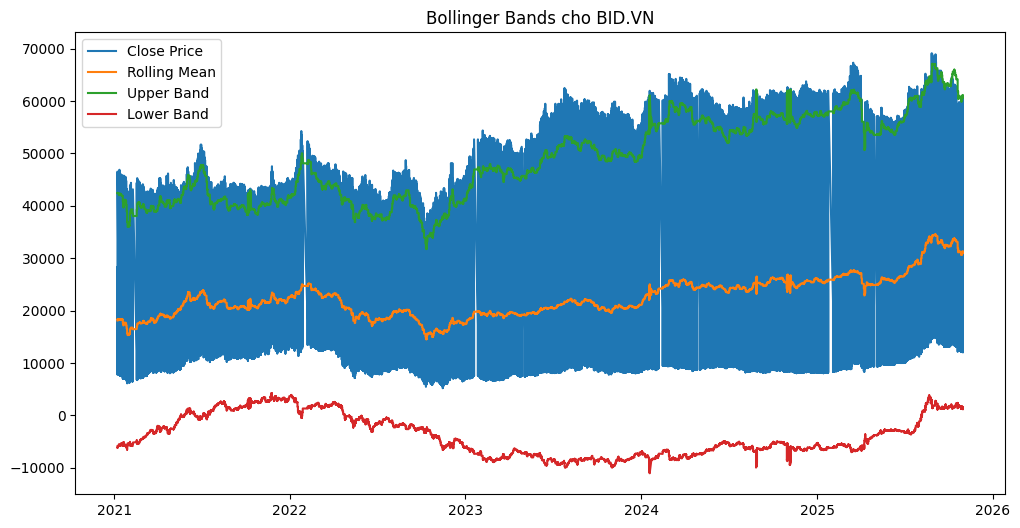

In [12]:
df.dropna(inplace=True)

# Bước 2: Áp dụng Time Series Modeling - Fit ARIMA để dự báo log returns
# Chọn order (p,d,q) đơn giản: (1,0,1) - Bạn có thể dùng auto_arima để tối ưu
model = ARIMA(df['Log_Return'], order=(1,0,1))
model_fit = model.fit()
forecast_steps = 1  # Dự báo 1 ngày tiếp theo
df['Forecast'] = model_fit.predict(start=0, end=len(df)-1)  # Dự báo in-sample cho đơn giản
# Để dự báo out-of-sample: forecast = model_fit.forecast(steps=forecast_steps)

# Bước 3: Áp dụng Volatility - Tính Bollinger Bands
window = 20  # Window cho mean và std
df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
df['Rolling_Std'] = df['Close'].rolling(window=window).std()
df['Upper_Band'] = df['Rolling_Mean'] + (df['Rolling_Std'] * 2)
df['Lower_Band'] = df['Rolling_Mean'] - (df['Rolling_Std'] * 2)
df.dropna(inplace=True)

# Bước 4: Xây dựng thuật toán giao dịch (kết hợp ARIMA forecast và Bollinger Bands)
# Ý tưởng: Mean Reversion với filter từ forecast
# - Buy (long) nếu giá < Lower_Band và forecast > 0 (dự báo tăng)
# - Sell (short) nếu giá > Upper_Band và forecast < 0 (dự báo giảm)
# - Hold nếu không
df['Signal'] = 0
df['Signal'] = np.where((df['Close'] < df['Lower_Band']) & (df['Forecast'] > 0), 1, df['Signal'])  # Buy
df['Signal'] = np.where((df['Close'] > df['Upper_Band']) & (df['Forecast'] < 0), -1, df['Signal'])  # Sell

# Tính position: Giả sử bắt đầu từ hold, thay đổi khi có signal
df['Position'] = df['Signal'].shift(1)  # Shift để tránh lookahead bias

# Bước 5: Backtest - Tính lợi nhuận
df['Strategy_Return'] = df['Position'] * df['Log_Return']
df['Cumulative_Market'] = np.cumsum(df['Log_Return'])  # Lợi nhuận thị trường
df['Cumulative_Strategy'] = np.cumsum(df['Strategy_Return'])  # Lợi nhuận chiến lược

# Tính Sharpe Ratio (giả sử risk-free rate = 0)
sharpe_ratio = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(252)  # Annualized

print(f"Sharpe Ratio của chiến lược: {sharpe_ratio:.2f}")

# Vẽ biểu đồ backtest
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Market'], label='Market Return')
plt.plot(df['Cumulative_Strategy'], label='Strategy Return')
plt.title(f'Backtest Chiến Lược cho {ticker}')
plt.legend()
plt.show()

# Vẽ Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Rolling_Mean'], label='Rolling Mean')
plt.plot(df['Upper_Band'], label='Upper Band')
plt.plot(df['Lower_Band'], label='Lower Band')
plt.title(f'Bollinger Bands cho {ticker}')
plt.legend()
plt.show()